# 패키지 임포트 & 상수 정의

In [33]:
# ================================================
# 📦 공통 패키지 (KMeans, XGBoost, MCLP)
# ================================================

# 데이터 처리
import pandas as pd
import numpy as np
import os

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import folium
from folium.plugins import MarkerCluster

# 진행 표시
from tqdm.notebook import tqdm

# KMeans (클러스터링)
from sklearn.cluster import KMeans

# XGBoost (수요 예측)
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# MCLP (최적 입지 선정)
from pulp import LpProblem, LpMaximize, LpVariable, lpSum

# ================================================
# ⚙️ 공통 상수 설정
# ================================================

# 데이터 경로
DATA_DIR = "../data/processed"
OUTPUT_DIR = "outputs/modeling"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# KMeans 설정
KMEANS_MODE = "manual"   # 'auto' 또는 'manual'
KMEANS_MANUAL_K = 5      # 수동일 경우 사용할 k 값

# XGBoost 설정
XGB_N_ESTIMATORS = 100

# MCLP 설정
COVERAGE_RADIUS = 0.02   # 위경도 기준 반경 (~2km)
FACILITY_LIMIT = 30      # 설치 가능한 충전소 개수 제한

# K means clustering

In [34]:
# 1. 패키지 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
import os

sns.set(style="whitegrid")

# 출력 디렉토리 생성
os.makedirs("../outputs/modeling", exist_ok=True)

In [36]:
# ================================================
# 📍 KMeans: Elbow Method로 최적 k 탐색
# ================================================

# 데이터 로드
grid = pd.read_csv(f"{DATA_DIR}/grid_system_processed.csv")

# 클러스터링 대상 feature 선택
features = grid[['demand_score', 'supply_score', 'center_lat', 'center_lon']].dropna()

In [37]:
# 3. Elbow Method로 최적 k 자동 탐색
inertias = []
k_range = range(2, 11)

for k in tqdm(k_range):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(features)
    inertias.append(model.inertia_)

# 기울기 변화 계산
inertia_diff = np.diff(inertias)
inertia_diff2 = np.diff(inertia_diff)

# 최대 변화량 지점 찾기 (두 번째 도함수 절댓값이 큰 곳)
optimal_k_idx = np.argmax(np.abs(inertia_diff2)) + 2  # k_range는 2부터 시작했기 때문에 +2
optimal_k = k_range[optimal_k_idx - 2]  # 실제 k 값 추출

print(f"자동으로 선택된 최적 k 값: {optimal_k}")

  0%|          | 0/9 [00:00<?, ?it/s]

자동으로 선택된 최적 k 값: 2


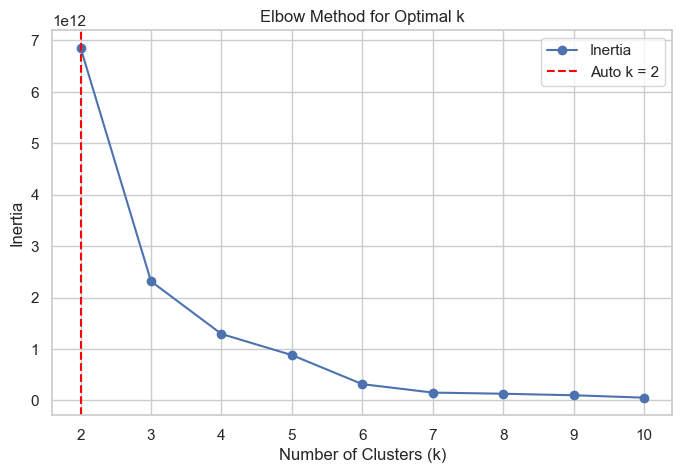

In [38]:
# 시각화
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o', label="Inertia")
plt.axvline(optimal_k, color='red', linestyle='--', label=f"Auto k = {optimal_k}")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.legend()
plt.grid(True)
plt.show()

In [39]:
# ================================================
# 📍 KMeans: 클러스터링 수행
# ================================================

# 최종 클러스터 개수 결정
k = KMEANS_MANUAL_K if KMEANS_MODE == 'manual' else optimal_k
print(f"선택된 k 값: {k} (mode = {KMEANS_MODE})")

# 클러스터링 실행
kmeans = KMeans(n_clusters=k, random_state=42)
grid['cluster'] = kmeans.fit_predict(features)

# 결과 확인
print("클러스터 분포:\n", grid['cluster'].value_counts())

선택된 k 값: 5 (mode = manual)
클러스터 분포:
 cluster
0    4878
1     442
3     284
4     181
2     178
Name: count, dtype: int64


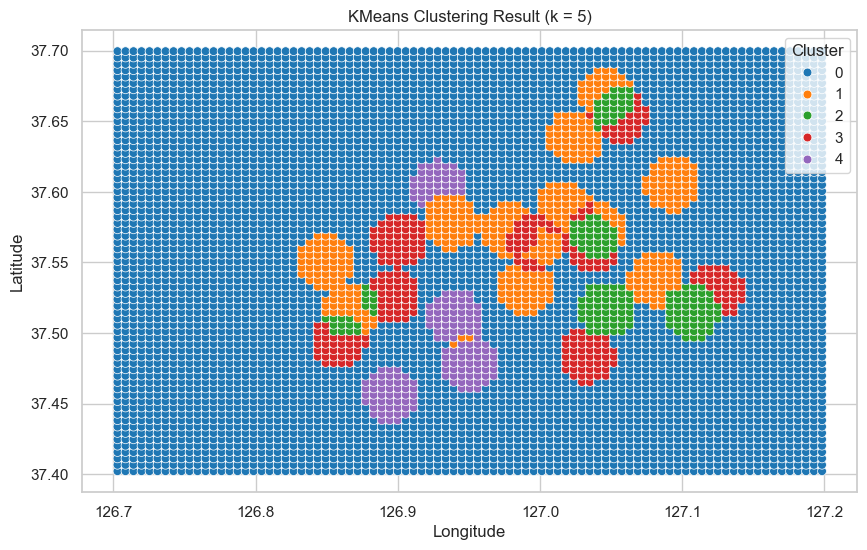

In [40]:
# 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=grid,
    x='center_lon', y='center_lat',
    hue='cluster',
    palette='tab10',
    s=40
)
plt.title(f"KMeans Clustering Result (k = {k})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [41]:
# 저장
grid.to_csv(f"{OUTPUT_DIR}/grid_with_cluster.csv", index=False)
print(f"클러스터링 결과 저장 완료: {OUTPUT_DIR}/grid_with_cluster.csv")

클러스터링 결과 저장 완료: outputs/modeling/grid_with_cluster.csv


# XGBoost

In [ ]:
# ================================================
# 📍 XGBoost: 수요 점수 예측 모델 학습
# ================================================

# 데이터 로드
df = pd.read_csv(f"{DATA_DIR}/grid_features.csv")

# 입력(X), 출력(y) 정의
X = df.drop(columns=['demand_score', 'grid_id', 'center_lat', 'center_lon'], errors='ignore')
y = df['demand_score']

# 결측치 제거
X = X.dropna()
y = y.loc[X.index]

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/grid_features.csv'

In [ ]:
# 학습/검증 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 모델 학습
model = XGBRegressor(n_estimators=XGB_N_ESTIMATORS, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("R²:", round(r2, 4))

In [ ]:
# 예측 vs 실제 시각화
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Demand Score")
plt.ylabel("Predicted")
plt.title("XGBoost Demand Prediction")
plt.grid(True)
plt.show()

In [ ]:
# 전체 데이터 예측 결과 저장
df['predicted_demand_score'] = model.predict(X)
df.to_csv(f"{DATA_DIR}/grid_features_with_prediction.csv", index=False)
print(f"예측 결과 저장 완료: {DATA_DIR}/grid_features_with_prediction.csv")

# MCLP

In [ ]:
# ================================================
# 📍 MCLP: 최적 입지 선정 (충전소 설치 위치)
# ================================================

# 예측 결과 포함된 데이터 로드
df = pd.read_csv(f"{DATA_DIR}/grid_features_with_prediction.csv")

# 수요 값 설정
df['demand'] = df['predicted_demand_score']

In [ ]:
# 커버리지 매트릭스 생성
sites = list(df.index)
demand_points = list(df.index)

coverage_matrix = {
    i: [j for j in demand_points if
        np.sqrt((df.loc[i, 'center_lat'] - df.loc[j, 'center_lat'])**2 +
                (df.loc[i, 'center_lon'] - df.loc[j, 'center_lon'])**2) <= COVERAGE_RADIUS]
    for i in sites
}

# MCLP 최적화 모델 정의
prob = LpProblem("Maximize_Coverage", LpMaximize)

# 설치 여부 변수
x = LpVariable.dicts("Site", sites, cat='Binary')
# 수요 커버 여부 변수
y = LpVariable.dicts("Covered", demand_points, cat='Binary')

# 목적 함수: 커버된 수요 총합 최대화
prob += lpSum(df.loc[j, 'demand'] * y[j] for j in demand_points)

# 제약조건: 설치 가능한 수 제한
prob += lpSum(x[i] for i in sites) <= FACILITY_LIMIT

# 제약조건: 수요지 j는 커버하는 사이트 i가 설치된 경우에만 커버됨
for j in demand_points:
    prob += y[j] <= lpSum(x[i] for i in coverage_matrix if j in coverage_matrix[i])

# 최적화 수행
prob.solve()

# 선택된 설치 위치 인덱스 추출
selected_sites = [i for i in sites if x[i].varValue == 1.0]
print("선택된 격자 수:", len(selected_sites))

# 선택 여부 컬럼 추가 및 저장
df['selected'] = df.index.isin(selected_sites).astype(int)
df.to_csv(f"{OUTPUT_DIR}/mclp_selected_sites.csv", index=False)
print(f"최적 입지 선정 결과 저장 완료: {OUTPUT_DIR}/mclp_selected_sites.csv")